In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model


# Read The LME Spot Price Data

In [6]:
metal = 'recommend'
price = pd.read_csv(metal+'.csv')

# Create return over several time horizon

In [3]:
price['return_1d'] = ((price['LMCADY'] / price['LMCADY'].shift(1)) -1)*100
price['return_3d'] = ((price['LMCADY'] / price['LMCADY'].shift(3)) -1)*100
price['return_5d'] = ((price['LMCADY'] / price['LMCADY'].shift(5)) -1)*100
price['return_7d'] = ((price['LMCADY'] / price['LMCADY'].shift(7)) -1)*100
price['return_10d'] = ((price['LMCADY'] / price['LMCADY'].shift(10)) -1)*100
price['return_15d'] = ((price['LMCADY'] / price['LMCADY'].shift(15)) -1)*100
price['return_20d'] = ((price['LMCADY'] / price['LMCADY'].shift(20)) -1)*100

# Read the Baidu Sentiment Score through analyzing each news title from Chinese new sources

In [4]:
sentiment = pd.read_csv('cu_sentiment.csv')
sentiment.drop(['url','title'],axis=1,inplace =True)

# Data Preprocessing

Since all data points in our file are unicode, we will define some functions to extract key information from the file and turn it into numerical value

In [5]:
def get_positive(string):
    return float(string.split(',')[0].split(',')[0][19:])
def get_confidence (string):
    return float(string.split(',')[1][16:])
def get_negative (string):
    return float(string.split(',')[2][19:])

In [6]:
sentiment['Pos'] = sentiment['Score'].apply(get_positive)
sentiment['Conf'] = sentiment['Score'].apply(get_confidence)
sentiment['Neg'] = sentiment['Score'].apply(get_negative)

# Create Indicator

Now we will create two indicators. 
1. First indicator will use the positive score - negative score, the larger the score, the more positive news will be. 
2. Second indicator will base on first indicator and times the confidence level in order to incorporate the factor related to confidence of the baidu api analysis into the indicator

In [7]:
sentiment['indi1'] = (sentiment['Pos'] -sentiment['Neg']) * 100
sentiment['indi2'] = (sentiment['Pos'] -sentiment['Neg']) * 100 * sentiment['Conf']

Now we will aggregate the indicator score of all news happened in a day into one final score

In [8]:
def create_indicator(df,indi):
    result =[]
    current_day = 0 
    current_score = 0
    num = 1 
    for day,score in zip(df['date'],df[indi]):
        if current_day == day:
            current_score += score
            num +=1
        else:
            result.append([current_day,current_score/num])
            current_day = day
            current_score = score
            num = 1
    result.append([current_day,current_score/num])
    final = pd.DataFrame(result[1:],columns=['Date','Score'])
    final['Date'] =  pd.to_datetime(final['Date'])
    return final


# Experiment relationship between backward return ratio and indicator 

Through our observation, we realize that most of the data we have are analyst reports which summarize events that have happended in the past (ranging from days to weeks) and analyse the impact of those events. Therefore, we can say that the most positive the score, the more positive the analyts in China feel about the market. 

Thus, the purpose of the following section is to experiment and check how the score might be related to financial market. We will check the following relationship:

#### 1. Relationship between today indicator score and the price changes for past few days( percentage changes between T and T - k)
The higher the score, more analyst are positive about the future, there will be more positive news that happend in the past and those news increase investors' risk appetite. Thus, we can assume that the price of today has incorporated those factors under efficient market theory. In other word, we should see a higher score correlated to a posivite price movement in the past

#### 2. Relationship between today indicator score and the price changes for next few days( percentage changes between T and T + k)
After checking the validity of the score, We will use the score to see whehter it has any predictive value in return.

#### 3. Relationship between today indicator score and the volatility changes for next few days
After checking the validity of the score, We will use the score to see whehter it has any predictive value in volatility.

Combine Indicator and price into one dataframe

In [9]:
indicator1 = create_indicator(sentiment,'indi1')
price_indicator = indicator1.merge(price, left_on='Date', right_on='Index',how='inner')
price_indicator.drop('Date',axis=1,inplace = True)
indicator2 = create_indicator(sentiment,'indi2')
price_indicator = indicator2.merge(price_indicator, left_on='Date', right_on='Index',how='inner')
price_indicator.drop('Index',axis=1,inplace = True)
price_indicator.rename(columns={'Score_x': 'Indi_1', 'Score_y': 'Indi_2'}, inplace=True)
price_indicator = price_indicator.reindex(index=price_indicator.index[::-1]).reset_index(drop = True)

In [10]:
def experiment_result(target,indicator,data):
    X = data[indicator].values
    X = np.reshape(X, (-1,1))
    data.plot.scatter(y =target,x=indicator,title = target +" vs "+indicator)
    print("Correlation is : " + str(data[indicator].corr(data[target])))
    target = data[target]
    model = linear_model.LinearRegression().fit(X,target)
    predicted = model.predict(X)
    plt.plot(data[indicator],predicted, 'r', label='fitted line')
    return

Correlation is : 0.02328719643667648


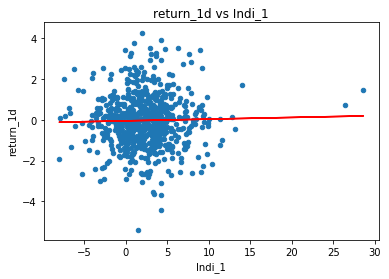

In [11]:
experiment_result('return_1d','Indi_1',price_indicator)

Correlation is : 0.14679568083533112


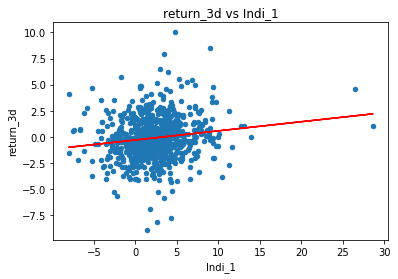

In [12]:
experiment_result('return_3d','Indi_1',price_indicator)

Correlation is : 0.18976197015027485


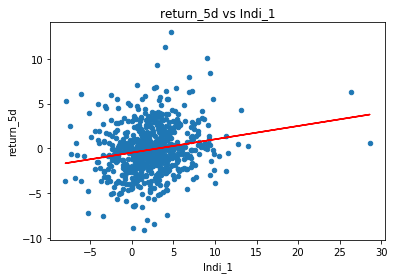

In [13]:
experiment_result('return_5d','Indi_1',price_indicator)

Correlation is : 0.1937082574225283


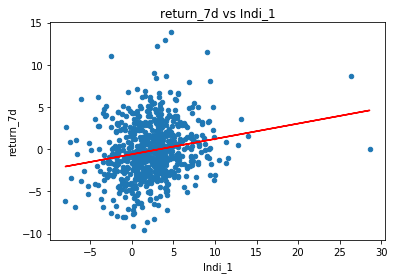

In [14]:
experiment_result('return_7d','Indi_1',price_indicator)

Correlation is : 0.16027944702736102


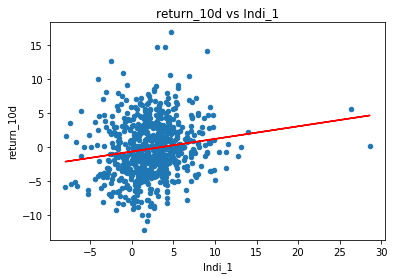

In [15]:
experiment_result('return_10d','Indi_1',price_indicator)

Correlation is : 0.0065549647513387715


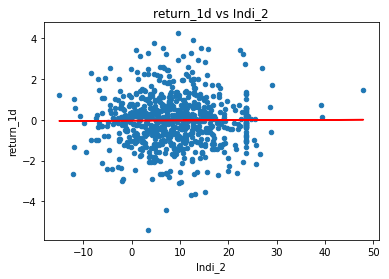

In [ ]:
experiment_result('return_1d','Indi_2',price_indicator)

Correlation is : 0.15125204273080303


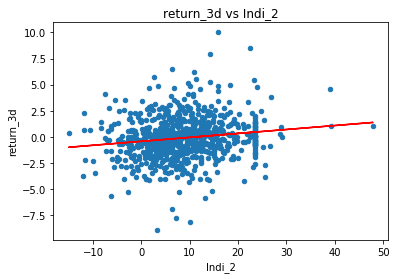

In [17]:
experiment_result('return_3d','Indi_2',price_indicator)

Correlation is : 0.20487974030227613


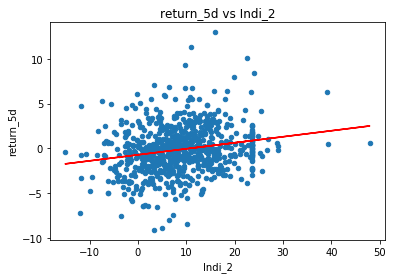

In [18]:
experiment_result('return_5d','Indi_2',price_indicator)

Correlation is : 0.21792973113777858


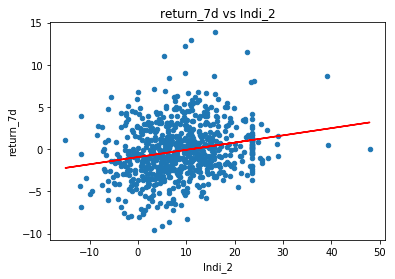

In [19]:
experiment_result('return_7d','Indi_2',price_indicator)

Correlation is : 0.21594631739228795


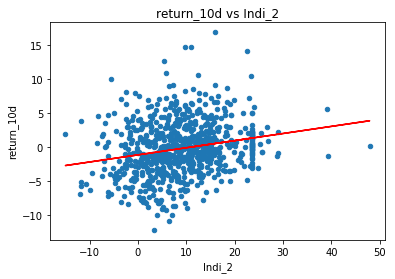

In [20]:
experiment_result('return_10d','Indi_2',price_indicator)

## Conclusion  1
From the experiment above, we are safe to assume that the sentiment score has incorporated the impact of past events in it instead of just being a random numerical value. Therefore, it makes sense for us to continue to improve the sentiment score as well as use it to do prediction for return

# Experiment relationship between forward return ratio and indicator 

In [61]:
price_forward = price.copy()

In [63]:
price_forward['return_1d'] = price_forward['return_1d'].shift(-1)
price_forward['return_3d'] = price_forward['return_3d'].shift(-3)
price_forward['return_5d'] = price_forward['return_5d'].shift(-5)
price_forward['return_7d'] = price_forward['return_7d'].shift(-7)
price_forward['return_10d'] = price_forward['return_10d'].shift(-10)
price_forward['return_15d'] = price_forward['return_15d'].shift(-15)
price_forward['return_20d'] = price_forward['return_20d'].shift(-20)

In [64]:
price_indicator_forward = indicator1.merge(price_forward, left_on='Date', right_on='Index',how='inner')
price_indicator_forward.drop('Date',axis=1,inplace = True)
price_indicator_forward = indicator2.merge(price_indicator_forward, left_on='Date', right_on='Index',how='inner')
price_indicator_forward.drop('Index',axis=1,inplace = True)
price_indicator_forward.rename(columns={'Score_x': 'Indi_1', 'Score_y': 'Indi_2'}, inplace=True)
price_indicator_forward = price_indicator_forward.reindex(index=price_indicator_forward.index[::-1]).reset_index(drop = True)
price_indicator_forward = price_indicator_forward.dropna()

Correlation is : -0.013995032053096053


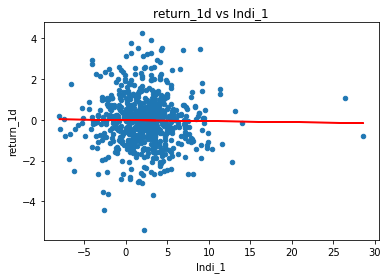

In [65]:
experiment_result('return_1d','Indi_1',price_indicator_forward)

Correlation is : -0.03972670878577915


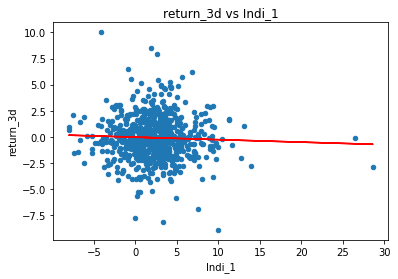

In [25]:
experiment_result('return_3d','Indi_1',price_indicator_forward)

Correlation is : -0.03261553977459017


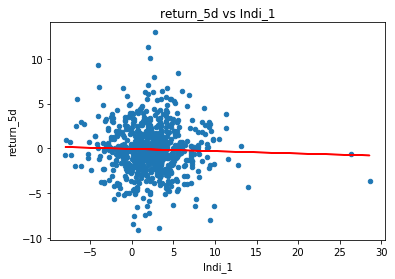

In [26]:
experiment_result('return_5d','Indi_1',price_indicator_forward)

Correlation is : -0.02133428537974847


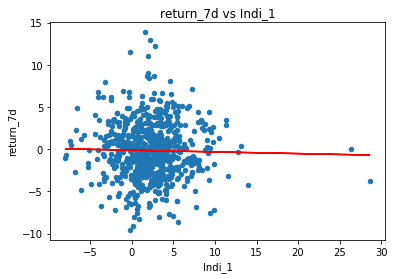

In [27]:
experiment_result('return_7d','Indi_1',price_indicator_forward)

Correlation is : -0.041488514105709626


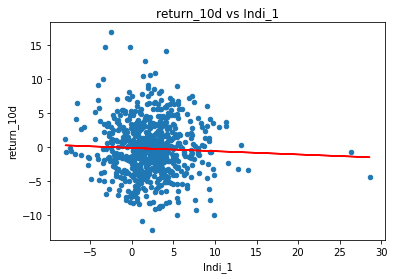

In [28]:
experiment_result('return_10d','Indi_1',price_indicator_forward)

Correlation is : 0.002112384726591384


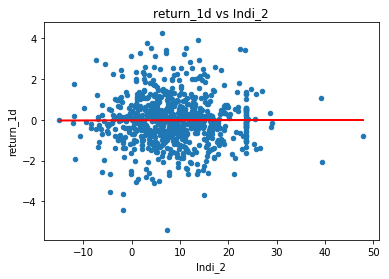

In [29]:
experiment_result('return_1d','Indi_2',price_indicator_forward)

Correlation is : -0.010323896711291719


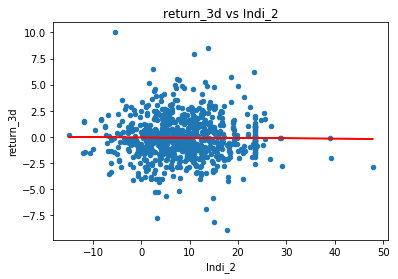

In [30]:
experiment_result('return_3d','Indi_2',price_indicator_forward)

Correlation is : -0.004304795352829787


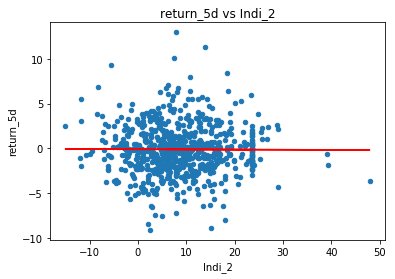

In [31]:
experiment_result('return_5d','Indi_2',price_indicator_forward)

Correlation is : -0.00519610401612772


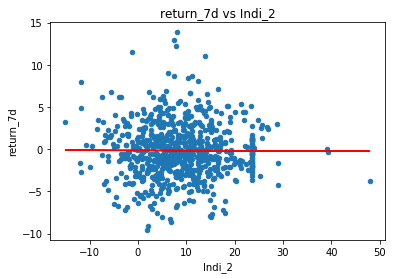

In [32]:
experiment_result('return_7d','Indi_2',price_indicator_forward)

Correlation is : -0.03545922096919563


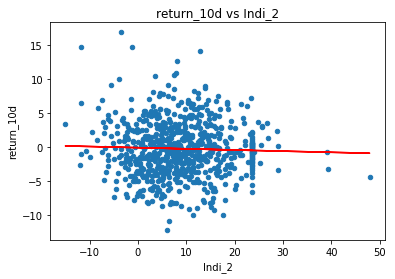

In [33]:
experiment_result('return_10d','Indi_2',price_indicator_forward)

## Conclusion  2
From the experiment above, we can tell sentiment score has zero correlation with future return. However, we can't conclude that it has zero predictive value in it. We will do other testing in next section 

# Experiment relationship between Volatility and indicator 

In [34]:
vol = price[[u'Index', u'LMCADY', u'return_1d']].copy()

In [35]:
vol['Std'] = np.log(vol[u'return_1d'].rolling(10).std())

In [36]:
vol['std_1d'] = vol['Std'].shift(-1)
vol['std_3d'] = vol['Std'].shift(-3)
vol['std_5d'] = vol['Std'].shift(-5)
vol['std_7d'] = vol['Std'].shift(-7)
vol['std_10d'] = vol['Std'].shift(-10)

In [37]:
vol = vol.dropna()

In [38]:
vol_indicator = indicator1.merge(vol, left_on='Date', right_on='Index',how='inner')
vol_indicator.drop('Date',axis=1,inplace = True)
vol_indicator = indicator2.merge(vol_indicator, left_on='Date', right_on='Index',how='inner')
vol_indicator.drop('Index',axis=1,inplace = True)
vol_indicator.rename(columns={'Score_x': 'Indi_1', 'Score_y': 'Indi_2'}, inplace=True)

Correlation is : -0.023951201691701136


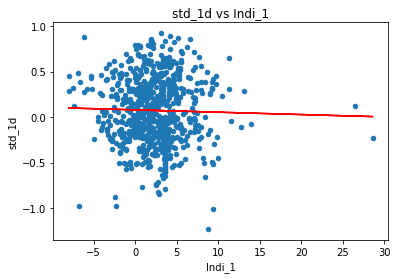

In [39]:
experiment_result('std_1d','Indi_1',vol_indicator)

Correlation is : -0.020623137500970452


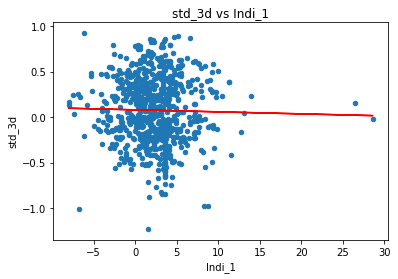

In [40]:
experiment_result('std_3d','Indi_1',vol_indicator)

Correlation is : -0.020033840891817537


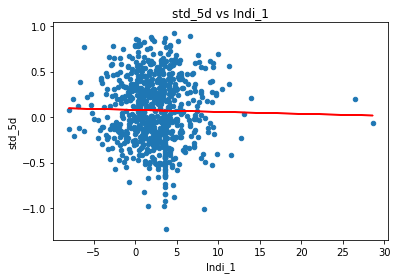

In [41]:
experiment_result('std_5d','Indi_1',vol_indicator)

Correlation is : -0.015812565725252255


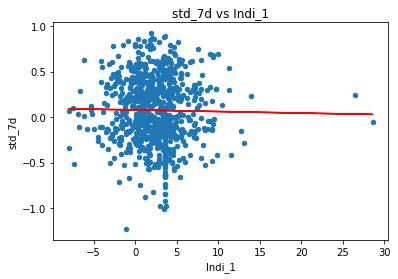

In [42]:
experiment_result('std_7d','Indi_1',vol_indicator)

Correlation is : -0.04975508214369957


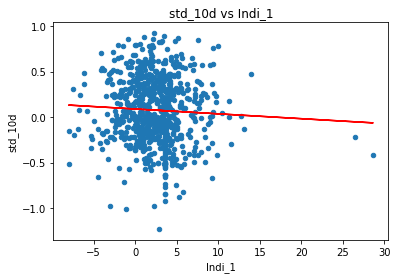

In [43]:
experiment_result('std_10d','Indi_1',vol_indicator)

In [ ]:
experiment_result('std_1d','Indi_2',vol_indicator)

Correlation is : -0.1001074329256575


Correlation is : -0.11566099963427907


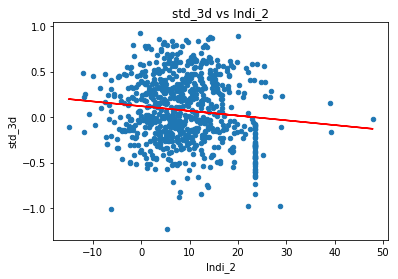

In [45]:
experiment_result('std_3d','Indi_2',vol_indicator)

Correlation is : -0.11818180021123131


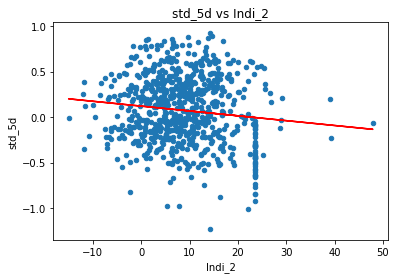

In [46]:
experiment_result('std_5d','Indi_2',vol_indicator)

Correlation is : -0.11833350501358304


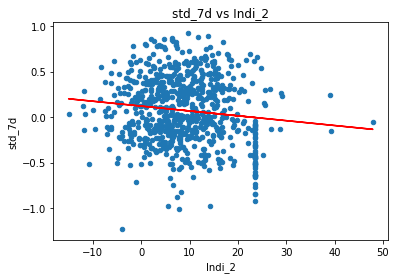

In [47]:
experiment_result('std_7d','Indi_2',vol_indicator)

Correlation is : -0.13643065326060325


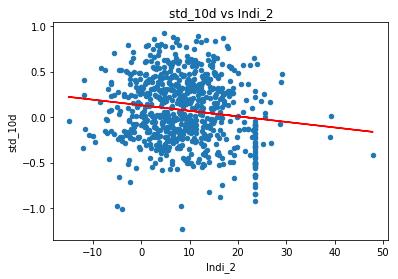

In [48]:
experiment_result('std_10d','Indi_2',vol_indicator)

## Conclusion  3
From the experiment above, we can tell sentiment score has certain negative correlation with future volatility. Therefore, it makes sense for us to continue to improve the sentiment score as well as use it to do prediction for volatility.


# Simple price prediction using indicator

In the following section, we will use the indicator to do simple prediction for different time horizon. The logis is as following:

1. If the indicator sign is bigger or equal to zero, we predict positive return for each time horizon
2. Else, negaive for each time horizon

Define a function to give positive sign to data point bigger than zero and negative sign to data point smaller than zero

In [66]:
def give_sign (data):
    if data>=0:
        return 1
    else:
        return -1

In [67]:
def prediction(result,data):
    indi_1 = data['Indi_1'].copy()
    indi_2 = data['Indi_2'].copy()
    sign_indi1 = indi_1.apply(give_sign)
    sign_indi2 = indi_2.apply(give_sign)
    
    sign_return = data[result].apply(give_sign)
    same_result_1= sign_return*sign_indi1
    reverse_result_1 = -sign_indi1*sign_return
    
    same_result_2= sign_return*sign_indi2
    reverse_result_2 = -sign_indi2*sign_return
    
    print('Number of positive in '+ result+ " : "+str(round(sign_return.value_counts()[1]/float(len(sign_return)),6)))
    print('Number of negative in '+ result+ " : "+str(round(sign_return.value_counts()[-1]/float(len(sign_return)),6)))
    print('Accuracy for following the same sign of Indicator 1 ' + result+ " : "+str(round(same_result_1.value_counts()[1]/float(len(sign_return)),6)))
    print('Accuracy for following the reverse sign of Indicator 1 '+ result+ " : "+str(round(reverse_result_1.value_counts()[1]/float(len(sign_return)),6)))
    print('Accuracy for following the same sign of Indicator 2 ' + result+ " : "+str(round(same_result_2.value_counts()[1]/float(len(sign_return)),6)))
    print('Accuracy for following the reverse sign of Indicator 2 '+ result+ " : "+str(round(reverse_result_2.value_counts()[1]/float(len(sign_return)),6)))

In [68]:
prediction('return_1d',price_indicator_forward)

Number of positive in return_1d : 0.502725
Number of negative in return_1d : 0.497275
Accuracy for following the same sign of Indicator 1 return_1d : 0.491826
Accuracy for following the reverse sign of Indicator 1 return_1d : 0.508174
Accuracy for following the same sign of Indicator 2 return_1d : 0.516349
Accuracy for following the reverse sign of Indicator 2 return_1d : 0.483651


In [69]:
prediction('return_3d',price_indicator_forward)

Number of positive in return_3d : 0.463215
Number of negative in return_3d : 0.536785
Accuracy for following the same sign of Indicator 1 return_3d : 0.476839
Accuracy for following the reverse sign of Indicator 1 return_3d : 0.523161
Accuracy for following the same sign of Indicator 2 return_3d : 0.485014
Accuracy for following the reverse sign of Indicator 2 return_3d : 0.514986


In [70]:
prediction('return_5d',price_indicator_forward)

Number of positive in return_5d : 0.459128
Number of negative in return_5d : 0.540872
Accuracy for following the same sign of Indicator 1 return_5d : 0.470027
Accuracy for following the reverse sign of Indicator 1 return_5d : 0.529973
Accuracy for following the same sign of Indicator 2 return_5d : 0.470027
Accuracy for following the reverse sign of Indicator 2 return_5d : 0.529973


In [71]:
prediction('return_7d',price_indicator_forward)

Number of positive in return_7d : 0.455041
Number of negative in return_7d : 0.544959
Accuracy for following the same sign of Indicator 1 return_7d : 0.444142
Accuracy for following the reverse sign of Indicator 1 return_7d : 0.555858
Accuracy for following the same sign of Indicator 2 return_7d : 0.452316
Accuracy for following the reverse sign of Indicator 2 return_7d : 0.547684


In [72]:
prediction('return_10d',price_indicator_forward)

Number of positive in return_10d : 0.450954
Number of negative in return_10d : 0.549046
Accuracy for following the same sign of Indicator 1 return_10d : 0.453678
Accuracy for following the reverse sign of Indicator 1 return_10d : 0.546322
Accuracy for following the same sign of Indicator 2 return_10d : 0.456403
Accuracy for following the reverse sign of Indicator 2 return_10d : 0.543597


In [73]:
prediction('return_15d',price_indicator_forward)

Number of positive in return_15d : 0.442779
Number of negative in return_15d : 0.557221
Accuracy for following the same sign of Indicator 1 return_15d : 0.450954
Accuracy for following the reverse sign of Indicator 1 return_15d : 0.549046
Accuracy for following the same sign of Indicator 2 return_15d : 0.456403
Accuracy for following the reverse sign of Indicator 2 return_15d : 0.543597


In [74]:
prediction('return_20d',price_indicator_forward)

Number of positive in return_20d : 0.441417
Number of negative in return_20d : 0.558583
Accuracy for following the same sign of Indicator 1 return_20d : 0.455041
Accuracy for following the reverse sign of Indicator 1 return_20d : 0.544959
Accuracy for following the same sign of Indicator 2 return_20d : 0.444142
Accuracy for following the reverse sign of Indicator 2 return_20d : 0.555858


## Conclusion  4
From the experiment above, we can observe that there is certain predictive value in this sentiment score. However, instead of following our initial strategy, we should go for different direction of the sentiment score. Further investigation will be required for us to run more complex model in order to improve the prediction